In [1]:
#In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The 
#features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you
#collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset {x(1),...,x(m)}. You suspect that 
#the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there 
#might also be some examples of servers acting anomalously within this dataset.

In [2]:
#You will use a Gaussian model to detect anomalous examples in your dataset. You will ﬁrst start on a 2D dataset that will 
#allow you to visualize what the algorithm is doing. On that dataset you will ﬁt a Gaussian distribution and then ﬁnd values
#that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection 
#algorithm to a larger dataset with many dimensions.

In [3]:
#%% ================== Part 1: Load Example Dataset  ===================
#%  We start this exercise by using a small dataset that is easy to
#%  visualize.
#%
#%  Our example case consists of 2 network server statistics across
#%  several machines: the latency and throughput of each machine.
#%  This exercise will help us find possibly faulty (or very fast) machines.
#%


#Importing...

import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D




#Reading the .mat file

mat_contents = sio.loadmat('E:\Machine Learning\Exercises\machine-learning-ex8\ex8\ex8data1.mat')

mat_contents


{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 15:37:10 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[13.04681517, 14.74115241],
        [13.40852019, 13.7632696 ],
        [14.19591481, 15.85318113],
        [14.91470077, 16.17425987],
        [13.57669961, 14.04284944],
        [13.92240251, 13.40646894],
        [12.82213164, 14.22318782],
        [15.67636615, 15.89169137],
        [16.16287532, 16.20299807],
        [12.66645095, 14.89908374],
        [13.98454962, 12.95800822],
        [14.06146043, 14.54908874],
        [13.38988671, 15.56202142],
        [13.39350475, 15.62698794],
        [13.97900926, 13.28061494],
        [14.16791259, 14.46583829],
        [13.96176145, 14.75182421],
        [14.45899735, 15.07018563],
        [14.58476372, 15.82743424],
        [12.07427074, 13.0671109 ],
        [13.5491294 , 15.53827677],
        [13.98625042, 14.78776304],
        [14.96991942, 16.51830493],
        [14.25576597, 15.294

#### Visualizing the Dataset

(307, 2)
(307, 2)
(307, 1)


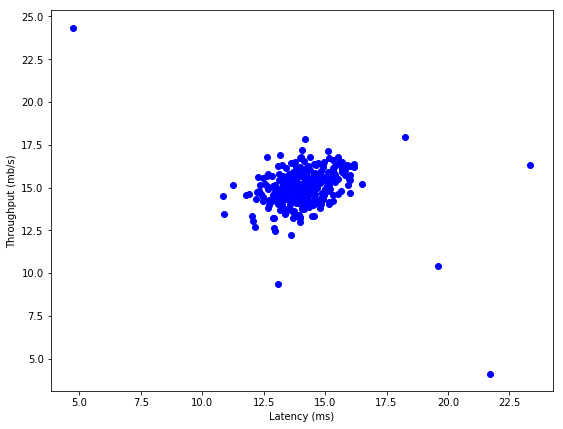

In [4]:
# Taking the Unlabeled data
X = mat_contents['X']

# Taking the cross validation data (labeled data)
Xval = mat_contents['Xval']
Yval = mat_contents['yval']


print(X.shape)
print(Xval.shape)
print(Yval.shape)


#plotting
plt.figure(figsize=(9,7))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

plt.plot(X[:,0],X[:,1],'bo')

# 1.1 Gaussian Distribution

To perform anomaly detection, you will ﬁrst need to ﬁt a model to the data’s distribution.
Given a training set {$x^{1}$,...,$x^{m}$} (where x(i) ∈ Rn), you want to estimate the Gaussian distribution for each of features xi. For each feature j = 1...n, you need to ﬁnd parameters $µ_{i}$ and $(σ^2)_{i}$ that ﬁt the data in the i-th dimension {$(x^{1})_j$,...,$(x^{m})_j$} (the j-th dimension of each example).



# 1.2 Estimating parameters for a Gaussian

In [5]:
#%% ================== Part 2: Estimate the dataset statistics ===================
#%  For this exercise, we assume a Gaussian distribution for the dataset.

#%  We first estimate the parameters of our assumed Gaussian distribution, 
#%  then compute the probabilities for each of the points and then visualize 
#%  both the overall distribution and where each of the points falls in 
#%  terms of that distribution.

In [6]:
#The input X is the dataset with each n-dimensional data point in one row
#The output is an n-dimensional vector mu, the mean of the data set
#and the variances sigma^2, an n x 1 vector

def estimateGaussian(X):
    m,n = X.shape
    
    # finding mean and variance column wise
    mu = X.mean(axis = 0)
    sigma2 = X.var(axis = 0)
    
    return mu,sigma2
    
    

In [7]:
#  Estimate mu(mean) and sigma2(sigma^2 : variance)
mu,sigma2 = estimateGaussian(X)

print(mu.shape,sigma2.shape)

(2,) (2,)


In [8]:
#Computes the probability density function of the examples X under the multivariate gaussian distribution with parameters mu
#and Sigma2. If Sigma2 is a matrix, it is treated as the covariance matrix. If Sigma2 is a vector then first convert it into
#covariance matrix( making of vector as diagonal element)


def multivariateGaussian(X, mu, sigma2):
    
    # no. of elements present in the mean matrix
    k = np.size(mu)
    
    #Checking whether sigma2(variance) is a vector or not,if it is then change it into diagona matrix
    #if mu.shape[0] == 1 or mu.shape[1] == 1:
    sigma2 = np.diag(sigma2)
    
    # Now computing the multivariate gaussian distribution
    
    # computing the 1st term(coefficient) i.e, 1/( ( (2pi)^(n/2) ) * det(sigma^0.5) )
    coefficient = 1/( ((2*np.pi)**(k/2)) * ((np.linalg.det(sigma2))**0.5) )
    
    
    # computing the second term(exponential term) e^(-0.5(x - mu)'(sigmaInverse)(x - mu) )
    
    #method 1
    #IF THIS CODE RUNS THEN THE PROBABILITY OBTAIN OF EACH ELEMENT WILL BE PRESENT AT THE DIAGONAL POSITION SO TO AVOID
    #THIS WE WILL COMPUTER BY THE SECOND METHOD,AFTER MATRIX MULTIPLICATION WHICH IS (X - MU).DOT(sigmaInverse) THEN WE WILL
    # DO ELEMENT WISE MULTIPLICATION OF THIS WITH THE MATRIX (X - MU)' THEN DO SUM COLUMN WISE AND WE WILL OBTAIN A 1D 
    # MATRIX THAT HAVING I'TH ELEMENT AS THE PROBABLITY OF I'TH ROW
    
    #exponential = np.exp(-0.5*(((X - mu).dot(np.linalg.inv(sigma2))).dot((X - mu).T)))
    
    
    
    # method 2
    exponential = np.exp(-0.5*( np.sum( ((X - mu).dot(np.linalg.inv(sigma2))) * (X - mu), axis = 1 ) ))
    
    return coefficient * exponential

In [9]:
# Returns the density of the multivariate normal at each data point (row) of X
p = multivariateGaussian(X, mu, sigma2)

print(p.shape)

(307,)


In [10]:
#%   VISUALIZEFIT Visualize the dataset and its estimated distribution.
#%   VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
#%   probability density function of the Gaussian distribution. Each example
#%   has a location (x1, x2) that depends on its feature values.

def visualizeFit(X, mu, sigma2):
    
    # making up the meshgrid
    X1,X2 = np.meshgrid(np.arange(0,35,0.5), np.arange(0,35,0.5)) # shape of X1,X2 =  (70,70)
    
    # Finding the multivariate gaussian distribution by sending it as (4900,2) data
    Z = multivariateGaussian(np.array([X1.flatten(),X2.flatten()]).T , mu , sigma2)
    
    Z = Z.reshape(X1.shape)

    plt.figure(figsize=(9,7))
    
    #plotting our training data
    plt.plot(X[:,0],X[:,1],'b.')

    # explicitly defining the levels
    levels = np.zeros((7,1))

    levels = np.power(10, np.arange(-20,0,3 , dtype='float') )
    
    # plotting the contour lines
    plt.contour(X1,X2,Z,levels, colors = ['black','blue','green','yellow','pink','purple','magenta'])


Text(0,0.5,'Throughput (mb/s)')

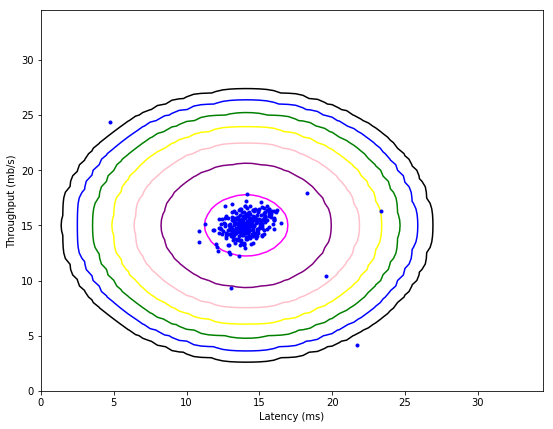

In [11]:
# Now we will visualize the contours of the ﬁtted Gaussian distribution. From your plot, you can see that most of the 
# examples are in the region with the highest probability, while the anomalous examples are in the regions with lower 
# probabilities

#Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

# 1.3 Selecting the threshold, ε

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold ε using the F1 score on a cross validation set. 

In [12]:
#%% ================== Part 3: Find Outliers ===================
#%  Now you will find a good epsilon threshold using a cross-validation set
#%  probabilities given the estimated Gaussian distribution
#% 

pval = multivariateGaussian(Xval, mu, sigma2)


In [13]:
#finds the best threshold to use for selecting outliers based on the results from a
#%   validation set (pval) and the ground truth (yval).

def selectThreshold(Yval, pval):
    
    bestEpsilon = 0#It will go from 0 to bestEpsilon by incrementing everytime we will obtain a better epsilon then previous
    bestF1 = 0     #It will go from 0 to bestF1 by incrementing everytime we will obtain a better F1 then previous
    F1 = 0 # It will be the current F1 for the loop
    
    # creating a list of epsilons between the range maximum values and minimum values of pval with a stepsize of their
    # range divided by 1000
    stepsize = (pval.max() - pval.min())/1000
    epsilons = np.arange(pval.min(), pval.max(), stepsize)

    #looping throughout all the epsilons
    for epsilon in epsilons:
        
        # Indexes where values of pval is less than epsilon indicating the predictions that they have y=1
        predictions = np.where(pval < epsilon)[0]
        
        # Indexes of Actual Positives of cross validation set
        Ypositive = np.where(Yval == 1)[0]
        
        # TruePositive will be the intersection of both actual positive indexes and predicted positive indexes
        TruePositive = np.size(np.intersect1d(predictions,Ypositive))
        
        # No. of actual Positives
        actualPositive = np.size(Ypositive)
        
        # No. of predicted positives
        predictedPositive = np.size(predictions)
        
        
        # Finding precision and recall, placed in try block because it can through an error of divide by zero so we will
        # skip that iteration further by placing continue
        try:
            Precision = TruePositive/predictedPositive

            Recall = TruePositive/actualPositive
        except:
            continue
        
        
        # Computing F1Score = 2PR/(P + R)
        F1 = (2*Precision*Recall)/(Precision + Recall)

        # If our current F1 score is better than our previous F1 Score then we will update our bestEpsilon and bestF1
        if(F1 > bestF1):
            bestF1 = F1
            bestEpsilon = epsilon

    # returning our best values of epsilon and F1
    return bestEpsilon,bestF1


In [14]:
epsilon,F1 = selectThreshold(Yval, pval)

print('Best Epsilon : ',epsilon,'\nBest F1 Score : ',F1)

Best Epsilon :  8.990852779269496e-05 
Best F1 Score :  0.8750000000000001


In [15]:
#  Find the indexes of outliers in the training set
outliers = np.where(pval < epsilon)[0]

### Separating the outliers(anomalies)

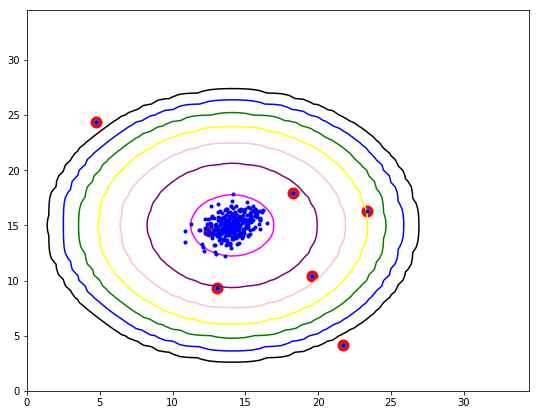

In [16]:
# Plotting our training data
visualizeFit(X,  mu, sigma2)

# Draw a red circle around those outliers
plt.scatter(X[outliers,0], X[outliers,1], s=80,edgecolors='red',linewidths=3)


# 1.4 High Dimensional Dataset 

The last part of the script ex8.m will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers. The script will use your code to estimate the Gaussian parameters (µi and σ2 i ), evaluate the probabilities for both the training data X from which you estimated the Gaussian parameters, and do so for the the cross-validation set Xval. Finally, it will use selectThreshold to ﬁnd the best threshold ε. You should see a value epsilon of about 1.38e-18, and 117 anomalies found.


In [17]:
#%% ================== Part 4: Multidimensional Outliers ===================
#%  We will now use the code from the previous part and apply it to a 
#%  harder problem in which more features describe each datapoint and only 
#%  some features indicate whether a point is an outlier.
#%

#%  Loads the second dataset. You should now have the
#%  variables X, Xval, yval in your environment

In [18]:
LargeData = sio.loadmat('E:\Machine Learning\Exercises\machine-learning-ex8\ex8\ex8data2.mat')

# Training data
XLarge = LargeData['X']

# cross validation data
XvalLarge = LargeData['Xval']
YvalLarge = LargeData['yval']

print(XLarge.shape,XvalLarge.shape,YvalLarge.shape)

(1000, 11) (100, 11) (100, 1)


In [19]:
# Estimating the gaussian Parameters
muLarge, sigma2Large = estimateGaussian(XLarge)

In [20]:
# Returns the density of the multivariate normal at each data point (row) of X

#Training set
pLarge = multivariateGaussian(XLarge, muLarge, sigma2Large)

#Cross validation set
pvalLarge = multivariateGaussian(XvalLarge, muLarge, sigma2Large)

In [21]:
#Finding the best Threshold using cross validation set
epsilonLarge, F1Large = selectThreshold(YvalLarge, pvalLarge)
print('Best Epsilon  : ',epsilonLarge,'\nBest F1 Score : ',F1Large)

Best Epsilon  :  1.377228890761358e-18 
Best F1 Score :  0.6153846153846154


In [22]:
# Finding the total no. of outliers found in the training set
print('Total anomalies(outliers) : ',sum(pLarge < epsilonLarge))

Total anomalies(outliers) :  117
